# 這邊在學校的 hub 上運行

## get a pretrained mobilenet model

In [1]:
from tensorflow.keras.applications.mobilenet import MobileNet
model = MobileNet(weights='imagenet',
                  include_top=True)
# save to keras model
model.save('mobilenet.h5')

## keras to onnx

In [4]:
!pip install -q onnx onnxmltools

In [2]:
import onnx
import onnxmltools
from tensorflow.keras.models import load_model

In [3]:
keras_path = 'mobilenet.h5'
onnx_path = 'mobilenet.onnx'
keras_model = load_model(keras_path)
onnx_model = onnxmltools.convert_keras(keras_model)
onnx.checker.check_model(onnx_model)
onnx.save(onnx_model, onnx_path)

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 248 -> 63


當我們在 Jetson Nano 上轉換成 trt 檔時，會出錯，因為他不支援動態輸入與輸出，因此需要將 onnx model 的輸入與輸出改成 1 (batch_size)
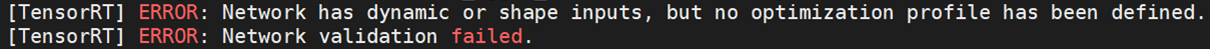

In [4]:
print(onnx_model.graph.input[0].type.tensor_type.shape.dim)
print(onnx_model.graph.output[0].type.tensor_type.shape.dim)

[dim_param: "N"
, dim_value: 224
, dim_value: 224
, dim_value: 3
]
[dim_param: "N"
, dim_value: 1000
]


In [5]:
onnx_model.graph.input[0].type.tensor_type.shape.dim[0].dim_value = 1
onnx_model.graph.output[0].type.tensor_type.shape.dim[0].dim_value = 1

In [6]:
print(onnx_model.graph.input[0].type.tensor_type.shape.dim)
print(onnx_model.graph.output[0].type.tensor_type.shape.dim)

[dim_value: 1
, dim_value: 224
, dim_value: 224
, dim_value: 3
]
[dim_value: 1
, dim_value: 1000
]


In [7]:
onnx.checker.check_model(onnx_model)
onnx.save(onnx_model, onnx_path)

# 這邊需在 jetson nano 上執行 
- python3 onnx2trt.py
- python3 inference.py

## onnx to tensorrt

In [ ]:
import os
import tensorrt as trt

In [ ]:
onnx_file = 'mobilenet.onnx'
trt_file = 'mobilenet.trt'
batch_size = 1

In [ ]:
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
"""Takes an ONNX file and creates a TensorRT engine to run inference with"""
with trt.Builder(TRT_LOGGER) as builder, builder.create_network(EXPLICIT_BATCH) as network, trt.OnnxParser(network, TRT_LOGGER) as parser:
    builder.max_workspace_size = 1<<28 # 256MiB
    builder.max_batch_size = batch_size
    builder.fp16_mode = True # fp32_mode -> False
    # Parse model file
    with open(onnx_file, 'rb') as model:
        print('Beginning ONNX file parsing')
        if not parser.parse(model.read()):
            print ('ERROR: Failed to parse the ONNX file.')
            for error in range(parser.num_errors):
                print (parser.get_error(error))
    print('Completed parsing of ONNX file')
    engine = builder.build_cuda_engine(network)
    print("Completed creating Engine")
    with open(trt_file, "wb") as f:
        f.write(engine.serialize())

## Inference

In [28]:
import cv2
import numpy as np

In [ ]:
def load_labels(label_file_path):
    labels = [line.rstrip('\n') for line in open(label_file_path)]
    return labels

def preprocess(img_path, img_size):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)[:, :, ::-1]
    img = np.float32(img)/255.0
    img = cv2.resize(img, (img_size, img_size))
    return img

In [30]:
# 讀進照片並進行前處理
img_path = 'tabby_tiger_cat.jpg'
img_size = 224
img = preprocess(img_path, img_size)

# 獲得 labels 的資訊
label_file_path = 'class_labels.txt'
labels = load_labels(label_file_path)

In [ ]:
# load trt engine
trt_path = 'mobilenet.trt'
with open(trt_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
    engine = runtime.deserialize_cuda_engine(f.read())
    
# 分配 buffers 給 inputs 和 outputs
inputs, outputs, bindings, stream = common.allocate_buffers(engine)
inputs[0].host = img

# inference
with engine.create_execution_context() as context:
    trt_outputs = common.do_inference_v2(context, 
                                         bindings=bindings, 
                                         inputs=inputs, 
                                         outputs=outputs, 
                                         stream=stream)
# 預測結果
pred = labels[trt_outputs[0].argmax(-1)]
print(f'Predicted: {pred}')